In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import qiskit
import qiskit.pulse
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, Drag, library, ScheduleBlock, Call
from qiskit.pulse.library import drag, GaussianSquare, Gaussian
from qiskit import pulse, transpile, schedule, assemble, execute
from qiskit import pulse
from qiskit.visualization import SchedStyle

my_style = qiskit.visualization.SchedStyle(figsize = (15, 5))
pulse_drawer = qiskit.visualization.pulse_drawer

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

coupling_map = backend.configuration().coupling_map
back_defaults = backend.defaults()
back_configuration = backend.configuration()
back_properties = backend.properties()
inst_map = back_defaults.instruction_schedule_map

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/pulse/qcstyle.py:126: DeprecationWarning: The legacy pulse drawer is deprecated along with this stylesheet. Please use new drawer `qiskit.visualization.pulse_drawer_v2` with new stylesheet classes provided by `qiskit.visualization.pulse_v2`. You can choose one of `IQXStandard`, `IQXSimple`, `IQXDebugging`.
  warnings.warn('The legacy pulse drawer is deprecated along with this stylesheet. '
ibmqfactory.load_account:WARNING:2021-04-20 12:40:15,417: Credentials are already in use. The existing account in the session will be replaced.


In [12]:
gate_errors_cx = [backend.properties().gate_error('cx', qubit_pair) for qubit_pair in coupling_map]
best_cx_error = min(gate_errors_cx)
best_qubit_pair = coupling_map[gate_errors_cx.index(min(gate_errors_cx))]
print("Best cx gate is qubit pair {} with cx error {:.4f} ({:.2f}%)".format(best_qubit_pair, best_cx_error, best_cx_error*100))

# do RB on swap gate between the qubits that have the cx gate with lowest error
q1 = best_qubit_pair[0]
q2 = best_qubit_pair[1]

control, target = q1, q2


############################# CX BASIS GATE ANALYSIS #############################

######################## controlled-X basis gate applied on control=q1, target=q2

# cX control target analysis

control_target_qc = QuantumCircuit(7,name="Control_Target_cX")

# apply standard cX(control, target)
control_target_qc.cx(control, target)
# transpile and schedule to get pulse instructions and channels
control_target_qc_transpiled = transpile(control_target_qc, backend, optimization_level=2)
control_target_sched = schedule(control_target_qc_transpiled, backend, inst_map=inst_map)
control_target_inst = control_target_sched.instructions
# save play instructions to list
cX_ControlTarget_pulses = [x[1] for x in control_target_inst if type(x[1])==Play]

######################## controlled-X basis gate applied on control=q2, target=q1

# cX target control analysis

target_control_qc = QuantumCircuit(7, name="Target_Control_cX")

# apply standard cX(target, control)
target_control_qc.cx(target, control)
# transpile and schedule to get pulse instructions and channels
target_control_qc_transpiled = transpile(target_control_qc, backend, optimization_level=2)
target_control_sched = schedule(target_control_qc_transpiled, backend, inst_map=inst_map)
target_control_inst = target_control_sched.instructions
# save play instructions to list
cX_TargetControl_pulses = [x[1] for x in target_control_inst if type(x[1])==Play]

Best cx gate is qubit pair [1, 3] with cx error 0.0060 (0.60%)


controlled-X for qubits 1 3


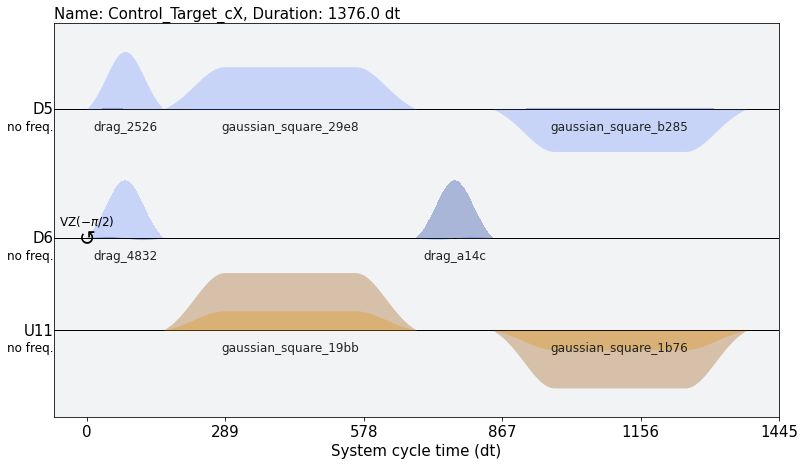

In [13]:
######################## PLOT cX SCHEDULES: 

print("controlled-X for qubits", control, target)
control_target_sched.draw()

controlled-X for qubits 3 1


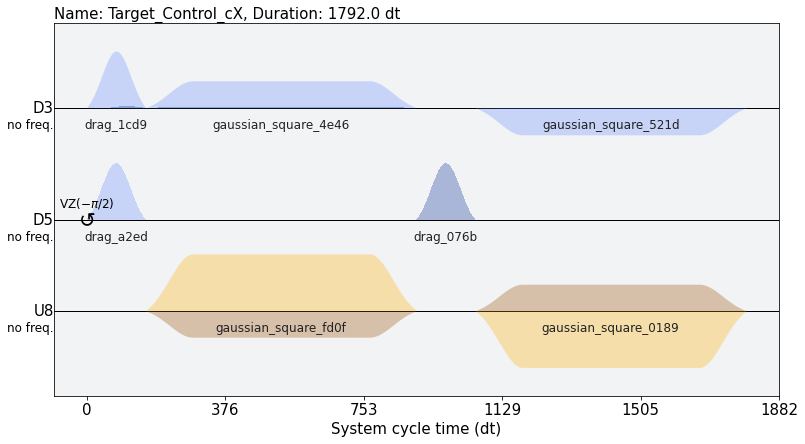

In [14]:
######################## PLOT cX SCHEDULES: 

print("controlled-X for qubits", target, control)
target_control_sched.draw()

In [24]:
########################################## FINAL CODE BLOCK ##########################################

def extract_cx_scheds(control, target, backendname):
    # args: control qubit indexnum (int), target qubit indexnum (int), backendname (str)
    # returns: two CX gate Schedules [pri_sched, sec_sched] sorted by gatetime
    import qiskit.pulse
    from qiskit import pulse, transpile, schedule, assemble, execute
    from qiskit.pulse import library, Play, Schedule, DriveChannel, ControlChannel, Waveform
    backend = provider.get_backend(backendname)
    coupling_map = backend.configuration().coupling_map
    back_defaults = backend.defaults()
    back_configuration = backend.configuration()
    back_properties = backend.properties()
    inst_map = back_defaults.instruction_schedule_map
    # cx control target
    ct_qc = QuantumCircuit(7)
    ct_qc.cx(control, target)
    ct_qc_transpiled = transpile(ct_qc, backend, optimization_level=2)
    ct_sched = schedule(ct_qc_transpiled, backend, inst_map=inst_map)
    ct_sched_dur = ct_sched.duration
    # cx target control
    tc_qc = QuantumCircuit(7)
    tc_qc.cx(control, target)
    tc_qc_transpiled = transpile(tc_qc, backend, optimization_level=2)
    tc_sched = schedule(tc_qc_transpiled, backend, inst_map=inst_map)
    tc_sched_dur = tc_sched.duration
    # select pri(or) and sec(undary) schedules based on their duration:
    if tc_sched_dur < ct_sched_dur :
        pri_sched, sec_sched = tc_sched, ct_sched
    else:
        pri_sched, sec_sched = ct_sched, tc_sched 
        
    return [[pri_sched, sec_sched], [ct_sched, tc_sched]]

def make_custom_swap_sched(control, target, backendname):
    # args: control qubit indexnum (int), target qubit indexnum (int), backendname (str)
    # returns: swap Schedule
    pri_sched, sec_sched = extract_cx_scheds(control, target, backendname)[0][0], extract_cx_scheds(control, target, 
                                                                                                    backendname)[0][1]
    ct_sched, tc_sched = extract_cx_scheds(control, target, backendname)[1][0], extract_cx_scheds(control, target, 
                                                                                                  backendname)[1][1]
    if ct_sched == sec_sched:
        control, target = target, control
        ct_sched, tc_sched = tc_sched, ct_sched 

    # storages for single q rotations
    control_sx_pulse = inst_map.get('sx',control).instructions[0][1].pulse
    control_sx_channel = inst_map.get('sx',control).instructions[0][1].channel
    control_x_pulse = inst_map.get('x',control).instructions[0][1].pulse
    control_x_channel = inst_map.get('x',control).instructions[0][1].channel
    target_sx_pulse = inst_map.get('sx',target).instructions[0][1].pulse
    target_sx_channel = inst_map.get('sx',target).instructions[0][1].channel
    target_x_pulse = inst_map.get('x',target).instructions[0][1].pulse
    target_x_channel = inst_map.get('x',target).instructions[0][1].channel

    # lists with CR pulses and uchans
    ct_pulses = [(x[1].pulse,x[1].channel) for x in ct_sched.instructions if type(x[1])== Play]
    tc_pulses = [(x[1].pulse,x[1].channel) for x in tc_sched.instructions if type(x[1])== Play]

    ct_CRs = [x for x in ct_pulses if type(x[1]) == ControlChannel]
    tc_CRs = [x for x in tc_pulses if type(x[1]) == ControlChannel]

    ct_CR_cancellations = [x for x in ct_pulses if (type(x[1]) == DriveChannel) and (type(x[0])==GaussianSquare)]
    tc_CR_cancellations = [x for x in tc_pulses if (type(x[1]) == DriveChannel) and (type(x[0])==GaussianSquare)]   
    
    # building swap schedule
    
    with pulse.build(backend=backend,name="swapsched") as swapsched:
        with pulse.align_sequential(): 
           # 1 of 3 H gate layers
            with pulse.align_right():
                pulse.play(control_sx_pulse,control_sx_channel)
                pulse.play(target_sx_pulse, target_sx_channel)
            # CZ 1: 
            # CZ 1-1. CR control->target     
            with pulse.align_equispaced(max([ct_CRs[0][0].duration,ct_CR_cancellations[0][0].duration])):
                pulse.play(ct_CRs[0][0], ct_CRs[0][1])
                pulse.play(ct_CR_cancellations[0][0], ct_CR_cancellations[0][1])
            # X rotation between CRs control->target  
            pulse.play(control_x_pulse, control_x_channel)
           # CZ 1-2. CR control->target        
            with pulse.align_equispaced(max([ct_CRs[0][0].duration,ct_CR_cancellations[0][0].duration])):
                pulse.play(ct_CRs[1][0], ct_CRs[1][1])
                pulse.play(ct_CR_cancellations[1][0], ct_CR_cancellations[1][1])
            # 2 of 3 H gate layers
            with pulse.align_right():
                pulse.play(control_sx_pulse,control_sx_channel)
                pulse.play(target_sx_pulse, target_sx_channel)
            # CZ 2:
            # CZ 2-1. CR target -> control
            with pulse.align_equispaced(max([tc_CRs[0][0].duration,ct_CR_cancellations[0][0].duration])):
                pulse.play(tc_CRs[0][0], tc_CRs[0][1])
                pulse.play(tc_CR_cancellations[0][0], tc_CR_cancellations[0][1])
            # X rotation between CRs target -> control
            pulse.play(target_x_pulse, target_x_channel)
            # CZ 2-2. CR target -> control
            with pulse.align_equispaced(max([tc_CRs[0][0].duration,ct_CR_cancellations[0][0].duration])):
                pulse.play(tc_CRs[1][0], tc_CRs[1][1])
                pulse.play(tc_CR_cancellations[1][0], tc_CR_cancellations[1][1])
            # 3 of 3 H gate layers
            with pulse.align_right():
                pulse.play(control_sx_pulse,control_sx_channel)
                pulse.play(target_sx_pulse, target_sx_channel)
                    # CZ 3: 
            # 3-1. CR control->target     
            with pulse.align_equispaced(max([ct_CRs[0][0].duration,ct_CR_cancellations[0][0].duration])):
                pulse.play(ct_CRs[0][0], ct_CRs[0][1])
                pulse.play(ct_CR_cancellations[0][0], ct_CR_cancellations[0][1])
            # X rotation between CRs control->target  
            pulse.play(control_x_pulse, control_x_channel)
           # 3-2. CR control->target        
            with pulse.align_equispaced(max([ct_CRs[0][0].duration,ct_CR_cancellations[0][0].duration])):
                pulse.play(ct_CRs[1][0], ct_CRs[1][1])
                pulse.play(ct_CR_cancellations[1][0], ct_CR_cancellations[1][1])
                
            return swapsched
        
def get_swap_schedule_block(control, target, backendname):
    # args: control qubit indexnum (int), target qubit indexnum (int), backendname (str)
    # returns: faster swap schedule (ScheduleBlock Obj)
    sched_1 = make_custom_swap_sched(control, target, backendname)
    sched_2 = make_custom_swap_sched(target,control, backendname)
    if sched_1.duration < sched_2.duration:
        best_sched = sched_1
    else:
        best_sched = sched_2
    swap_sched = Schedule()
    swap_sched += Call(best_sched)
    return swap_sched

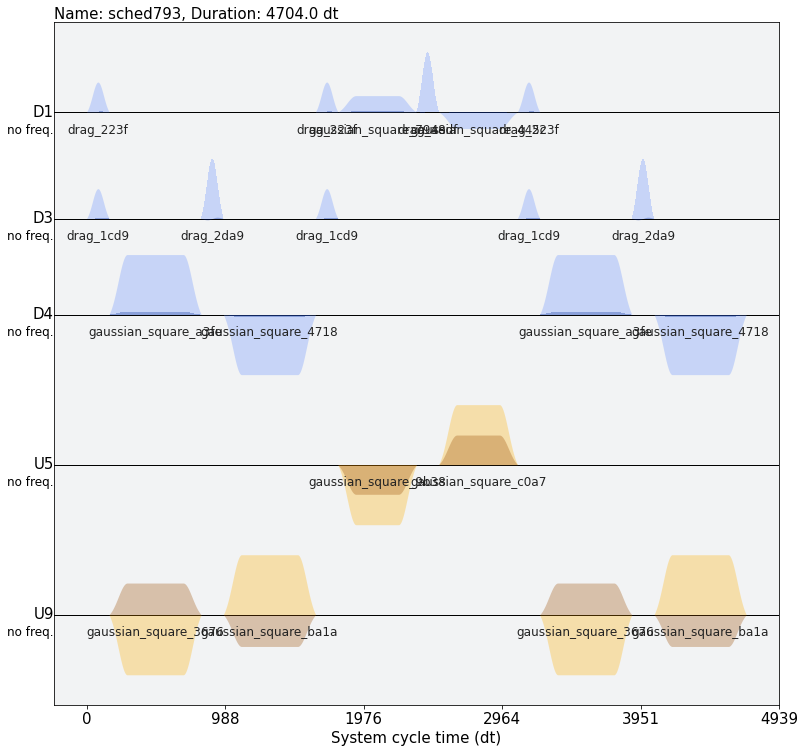

In [25]:
backendname = 'ibmq_casablanca'
swapschedule = get_swap_schedule_block(q1,q2,backendname)
swapschedule.draw()

In [36]:
def schedule_exited_state(qubit_indexnum):
    import qiskit.pulse
    from qiskit import pulse, transpile, schedule, assemble, execute
    from qiskit.pulse import library, Play, Schedule, DriveChannel, ControlChannel, Waveform
    backend = provider.get_backend(backendname)
    coupling_map = backend.configuration().coupling_map
    back_defaults = backend.defaults()
    back_configuration = backend.configuration()
    back_properties = backend.properties()
    inst_map = back_defaults.instruction_schedule_map
    circ = QuantumCircuit(7)
    circ.x(qubit_indexnum)
    circ_transpiled = transpile(circ, backend, optimization_level=1)
    circ_sched = schedule(circ_transpiled, backend, inst_map=inst_map)
    return circ_sched
    

In [48]:
q1_exited_sched = schedule_exited_state(q1)
q2_exited_sched = schedule_exited_state(q2)

inst_sched_map = backend.defaults().instruction_schedule_map
measure_q1 = inst_sched_map.get('measure', q1)
measure_q2 = inst_sched_map.get('measure', q2)

In [50]:
# Create two schedules to test SWAP

# start with: q1 in ground state, q2 in exited state
# expected outcome: q2 in ground state, q1 in exited state
q1_exited_schedule = pulse.Schedule(name="ground state")
q1_exited_schedule += q1_exited_sched
q1_exited_schedule += swapschedule
q1_exited_schedule += measure_q1
q1_exited_schedule += measure_q2


# start with: q2 in ground state, q1 in exited state
# expected outcome: q1 in ground state, q2 in exited state
q2_exited_schedule = pulse.Schedule(name="excited state")
q2_exited_schedule += q2_exited_sched
q2_exited_schedule += swapschedule
q2_exited_schedule += measure_q1
q2_exited_schedule += measure_q2

In [61]:
from qiskit import assemble

q1_test_program = assemble(q1_exited_schedule,
                        backend=backend, 
                        meas_level=1,
                        meas_return='avg',
                        shots=1024)

q2_test_program = assemble(q2_exited_schedule,
                        backend=backend, 
                        meas_level=1,
                        meas_return='avg',
                        shots=1024)

In [ ]:
#job = backend.run(q1_test_program)
#job.job_id()
jobid = '607ed1b20336b7056402c970'
job = backend.retrieve_job(jobid)

from qiskit.tools.monitor import job_monitor
job_monitor(job)


In [ ]:
#job = backend.run(q2_test_program)
#job.job_id()
jobid = '607ed192085eaf68f7b75ee9'
job = backend.retrieve_job(jobid)

from qiskit.tools.monitor import job_monitor
job_monitor(job)